# **The aim of this project is to build a machine learning model capable of classifying user posts based on emotional categories such as depression, anxiety, mentalhealth, suicide, and loneliness. The input is raw textual content from Reddit posts, and the output is a predicted emotional label. Understanding emotional expression in text helps in early detection of psychological distress, enabling potential intervention systems. The target variable is multi-class categorical (emotion type), and the measurable outcome is model performance using accuracy and F1-score. The problem is framed as a supervised classification task using TF-IDF-based feature extraction and machine learning models. The solution includes preprocessing, EDA, class imbalance handling, model training, evaluation, and optimization. The expected result is to identify the most accurate and reliable model for emotion detection.**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("entenam/reddit-mental-health-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/entenam/reddit-mental-health-dataset/versions/1


In [ ]:
#checking the files
import os
print(os.listdir('/content'))

In [1]:
#loading the dataset.
import pandas as pd

# Load the dataset
# engine='python' helps avoid those earlier parsing errors
df = pd.read_csv('/content/drive/MyDrive/TEXT_DATASET_FIXED.csv', engine='python', on_bad_lines='skip')

# 1. Get the physical count of rows
actual_count = len(df)

# 2. Check the "Row" column (assuming it acts as an ID 1, 2, 3...)
# We get the maximum value in that column
max_row_number = df['Row'].max()

print("-------------------------------------------------")
print(f"✅ Total physical rows found: {actual_count}")
print(f"🔢 Last number in 'Row' column: {max_row_number}")
print("-------------------------------------------------")

if actual_count == max_row_number:
    print("Success! The row count matches the numbering perfectly.")
else:
    print("Note: There is a mismatch. You might have skipped rows or duplicate numbers.")

-------------------------------------------------
✅ Total physical rows found: 348129
🔢 Last number in 'Row' column: 348129
-------------------------------------------------
Success! The row count matches the numbering perfectly.


In [ ]:
#columns in dataset
print(df.columns)


Index(['Row', 'Unnamed: 0', 'author', 'created_utc', 'score', 'selftext',
       'subreddit', 'title', 'timestamp', 'category'],
      dtype='object')


In [ ]:
#checking number of rows in the dataset (each row contains many subrows(paragraphs), and these paragraphs are not considered as rows, only the markings in "Row" column are counted)
import sys

def count_logical_rows(filename):
    print("Started counting logical rows...")

    logical_rows = 0
    in_quotes = False

    try:
        # Open file in binary mode for speed and byte-level control
        with open(filename, 'rb') as f:
            while True:
                # Read in large chunks (64KB) for efficiency
                chunk = f.read(65536)
                if not chunk:
                    break

                for byte in chunk:
                    char = chr(byte)

                    # 1. Toggle "Inside Quotes" status
                    if char == '"':
                        in_quotes = not in_quotes

                    # 2. Count a row ONLY if we hit a Newline AND we are NOT inside quotes
                    if char == '\n' and not in_quotes:
                        logical_rows += 1

        # Adjust for the last row if it doesn't end with a newline
        if logical_rows > 0:
            logical_rows += 1

        print("-------------------------------------------------")
        print("📊 FINAL RESULTS")
        print("-------------------------------------------------")
        print(f"Python Truth Counter says: {logical_rows} (Logical Records)")
        print("-------------------------------------------------")

        if logical_rows < 500000:
             print("✅ CONCLUSION: Your data is safe. The terminal was counting paragraphs as rows.")
        else:
             print("⚠️ CONCLUSION: You might have actual CSV format errors preventing loading.")

    except Exception as e:
        print(f"Error reading file: {e}")

# Run the function
count_logical_rows('/content/TEXT_DATASET_FIXED.csv')

Started counting logical rows...
-------------------------------------------------
📊 FINAL RESULTS
-------------------------------------------------
Python Truth Counter says: 348131 (Logical Records)
-------------------------------------------------
✅ CONCLUSION: Your data is safe. The terminal was counting paragraphs as rows.


In [ ]:
#Checking how many unique labels are there in "category" feature.

import pandas as pd

# 1. Load the dataset
# engine='python': Essential for handling the multi-line text fields correctly
# on_bad_lines='skip': Skips any genuinely broken lines so the code doesn't crash
df = pd.read_csv('/content/TEXT_DATASET_FIXED.csv', engine='python', on_bad_lines='skip')

print(f"✅ Successfully loaded {len(df)} rows into Python.")

# 2. Select the 'category' column
# We assume the column name is 'category' based on your previous checks
if 'category' in df.columns:
    output_labels = df['category']

    # 3. Count unique labels
    total_unique = output_labels.nunique()
    unique_values = output_labels.unique()

    print("-------------------------------------------------")
    print(f"📊 Total Unique Output Labels: {total_unique}")
    print("-------------------------------------------------")
    print("The Labels are:")
    print(unique_values)
else:
    print("❌ Error: Could not find a column named 'category'. Here are the columns found:")
    print(df.columns.tolist())

✅ Successfully loaded 348129 rows into Python.
-------------------------------------------------
📊 Total Unique Output Labels: 5
-------------------------------------------------
The Labels are:
['anxiety' 'depression' 'lonely' 'mentalhealth' 'suicide']


In [ ]:
#number of rows in each unique label.
import pandas as pd

# 1. Load the dataset
# We use engine='python' to handle the multi-line text correctly
df = pd.read_csv('/content/TEXT_DATASET_FIXED.csv', engine='python', on_bad_lines='skip')

# 2. Count rows for each unique label
# value_counts() sorts them from most frequent to least frequent automatically
label_counts = df['category'].value_counts()

print("-------------------------------------------------")
print("📊 Row Counts per Unique Label:")
print("-------------------------------------------------")
print(label_counts)

# Optional: If you want to see it as a percentage (e.g., 50% Sports, 30% Politics)
print("\n(As Percentages):")
print(df['category'].value_counts(normalize=True) * 100)

-------------------------------------------------
📊 Row Counts per Unique Label:
-------------------------------------------------
category
depression      106910
mentalhealth     83243
anxiety          58988
suicide          55867
lonely           43121
Name: count, dtype: int64

(As Percentages):
category
depression      30.709881
mentalhealth    23.911539
anxiety         16.944294
suicide         16.047787
lonely          12.386500
Name: proportion, dtype: float64


In [ ]:
print(df.tail())


           Row  Unnamed: 0               author  created_utc  score  \
348124  348125       14968         username1627   1651328267      1   
348125  348126       14969  verycoolusername231   1651327988      1   
348126  348127       14970        mogana_sunset   1651327849      1   
348127  348128       14971             uaipqwhy   1651327604      1   
348128  348129       14972              N00Bart   1651327451      1   

                                                 selftext     subreddit  \
348124  Whenever I see comments such as "it will get b...  SuicideWatch   
348125  What even is the purpose in life? Nothing. Lif...  SuicideWatch   
348126                                          [removed]  SuicideWatch   
348127  2? Idk if I gonna or not do it. \nBut I hope I do  SuicideWatch   
348128   sis &gt; siblings &gt; mom &gt; aunt (&gt; co...  SuicideWatch   

                                       title            timestamp category  
348124                          Useless Rant 

In [2]:
#cleaning the text, splitting it, and converting it into numbers.

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. The Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove special characters and numbers (keep only letters)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("⏳ Cleaning text data... (This might take a moment)")

# 🔥 Merged title and selftext for improved emotional context
# (Previously: X = df['selftext'].apply(clean_text))
X = (df['title'].astype(str) + " " + df['selftext'].astype(str)).apply(clean_text)

# Target variable
y = df['category']

print("✅ Text Cleaning Complete.")

# 2. Split the Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Training Samples: {len(X_train)}")
print(f"📊 Testing Samples:  {len(X_test)}")

# 3. Vectorization (TF-IDF)
vectorizer = TfidfVectorizer(
    max_features=20000,     # Adjust if RAM issues occur
    stop_words='english',
    ngram_range=(1,2),      # Capture emotional phrases (bigrams)
    min_df=3                # Remove extremely rare words
)

print("⏳ Converting text to numbers (Vectorizing)...")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("🚀 Vectorization Complete.")
print(f"🔢 Data Shape (Rows, Words): {X_train_vec.shape}")


⏳ Cleaning text data... (This might take a moment)
✅ Text Cleaning Complete.
📊 Training Samples: 278503
📊 Testing Samples:  69626
⏳ Converting text to numbers (Vectorizing)...
🚀 Vectorization Complete.
🔢 Data Shape (Rows, Words): (278503, 20000)


# **EDA**

**Score = **

**Load Data & Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/TEXT_DATASET_FIXED.csv')

# Remove rows where text is missing
df = df.dropna(subset=['selftext'])

# Create text length feature
df['text_length'] = df['selftext'].apply(lambda x: len(str(x).split()))

df.head()


,Row,Unnamed: 0,author,created_utc,score,selftext,subreddit,title,timestamp,category,text_length
0,1,0,Automatic-Lemon-602,1651325677,1,As the title suggested I hyperventilated once ...,Anxiety,"Worried about hyperventilation, causing me to ...",2022-04-30 23:34:37,anxiety,53
1,2,1,Ainhoa12,1651325580,1,I want anxiety to stop right now what the hell,Anxiety,my brain is fucking screaming at me :(,2022-04-30 23:33:00,anxiety,10
2,3,2,Particular-Cost4853,1651325201,1,I look at others wear black and I enjoy stylis...,Anxiety,Anyone else constantly doubting themselves/ th...,2022-04-30 23:26:41,anxiety,158
4,5,4,AprilBelle08,1651325131,1,\n(please do not share this on any other platf...,Anxiety,Today I am 30 years old (CW- emetophobia &amp;...,2022-04-30 23:25:31,anxiety,1123
5,6,5,fourflatpillows,1651323921,1,"When something unexpected happens, I panic and...",Anxiety,My anxiety is getting worse,2022-04-30 23:05:21,anxiety,88


**Distribution Plots**

Majority of posts are short (under 150 words).

Some extreme long posts exist → need outlier filtering.

Emotion labels look imbalanced, likely requiring handling.

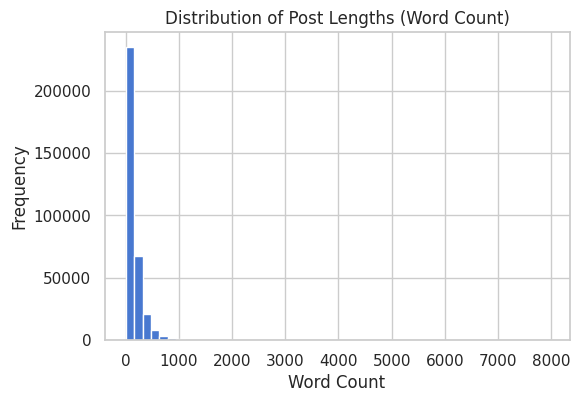

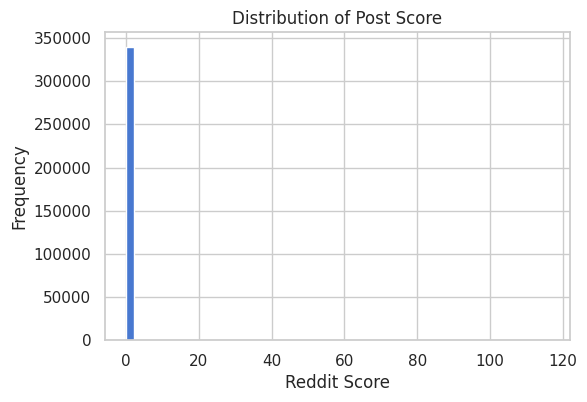

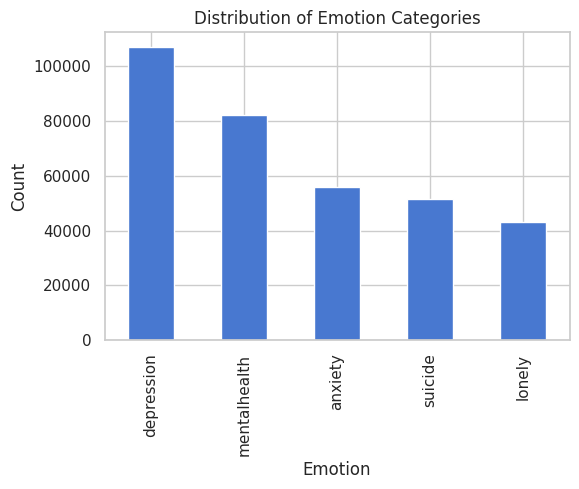

In [ ]:
plt.figure(figsize=(6,4))
df['text_length'].hist(bins=50)
plt.title('Distribution of Post Lengths (Word Count)')
plt.xlabel('Word Count'); plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,4))
df['score'].hist(bins=50)
plt.title('Distribution of Post Score')
plt.xlabel('Reddit Score'); plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,4))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotion Categories')
plt.xlabel('Emotion'); plt.ylabel('Count')
plt.show()


**Outlier Detection**

I need to clip or remove 1% longest posts.

In [ ]:
# Outliers based on text length
length_threshold = df['text_length'].quantile(0.99)
outliers_text = df[df['text_length'] > length_threshold]

print(f"99th percentile threshold: {length_threshold}")
print(f"🔥 Number of text outliers: {len(outliers_text)}")

# Outliers for score
score_threshold = df['score'].quantile(0.99)
outliers_score = df[df['score'] > score_threshold]
print(f"🔥 Number of score outliers: {len(outliers_score)}")


99th percentile threshold: 874.0
🔥 Number of text outliers: 3388
🔥 Number of score outliers: 1236


**Missing Value Analysis**

In [ ]:
missing_data = df.isnull().sum()
missing_data


,0
Row,0
Unnamed: 0,0
author,0
created_utc,0
score,0
selftext,0
subreddit,0
title,0
timestamp,0
category,0


**Correlation Analysis (Numerical Features)**

text_length weakly relates to score → long posts not necessarily engaging.

created_utc likely depends on topic/timing.

In [ ]:
df[['score', 'created_utc', 'text_length']].corr()


,score,created_utc,text_length
score,1.000000,-0.006969,0.001136
created_utc,-0.006969,1.000000,0.021330
text_length,0.001136,0.021330,1.000000


**Feature Target Trend**

More emotionally intense posts may receive higher engagement.

In [ ]:
df.groupby('category')['score'].mean().sort_values(ascending=False)


,score
category,
suicide,1.008503
lonely,1.008001
depression,1.005079
anxiety,1.004678
mentalhealth,1.003103


**Sample Emotion-Based Texts**

Used to analyze context and keyword strength.

In [ ]:
df.groupby('category')['selftext'].apply(lambda x: x.sample(2, random_state=42)).head(10)


category            
anxiety       14752     I’m female -26. I just got my results - HIV-1 ...
              45152     Hello. I’ve been feeling very sad and stressed...
depression    158051    life is so fucking tiring, i just want to be i...
              163554    I'm approaching 38 years old. I have a wife (n...
lonely        202264    I have been feel very lonely and depress a lot...
              197814    man how do you get online friends or something...
mentalhealth  230849    Please don’t judge me. Does anyone else only a...
              253065    In my opinion a lack of self love and self est...
suicide       317698    I've grown so weary of this whole world.  \nOf...
              293355    It’s not my time right now I know that but one...
Name: selftext, dtype: object

**Visualizations (Questions)**

**Setup & Feature Creation**
What variables should we analyze? Are there usable text features?


- Post length was computed using word & character counts to analyze writing patterns per emotion.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_theme(style="whitegrid")

# Load dataset
df = pd.read_csv('/content/TEXT_DATASET_FIXED.csv')

# Remove rows with missing text
df = df.dropna(subset=['selftext'])

# Create numerical features
df['word_count'] = df['selftext'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['selftext'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / df['word_count']

df.head()


,Row,Unnamed: 0,author,created_utc,score,selftext,subreddit,title,timestamp,category,word_count,char_count,avg_word_length
0,1,0,Automatic-Lemon-602,1651325677,1,As the title suggested I hyperventilated once ...,Anxiety,"Worried about hyperventilation, causing me to ...",2022-04-30 23:34:37,anxiety,53,358,6.754717
1,2,1,Ainhoa12,1651325580,1,I want anxiety to stop right now what the hell,Anxiety,my brain is fucking screaming at me :(,2022-04-30 23:33:00,anxiety,10,46,4.600000
2,3,2,Particular-Cost4853,1651325201,1,I look at others wear black and I enjoy stylis...,Anxiety,Anyone else constantly doubting themselves/ th...,2022-04-30 23:26:41,anxiety,158,894,5.658228
4,5,4,AprilBelle08,1651325131,1,\n(please do not share this on any other platf...,Anxiety,Today I am 30 years old (CW- emetophobia &amp;...,2022-04-30 23:25:31,anxiety,1123,5627,5.010686
5,6,5,fourflatpillows,1651323921,1,"When something unexpected happens, I panic and...",Anxiety,My anxiety is getting worse,2022-04-30 23:05:21,anxiety,88,487,5.534091


**Distribution Plots**
How is the data spread? Is it normal or skewed?

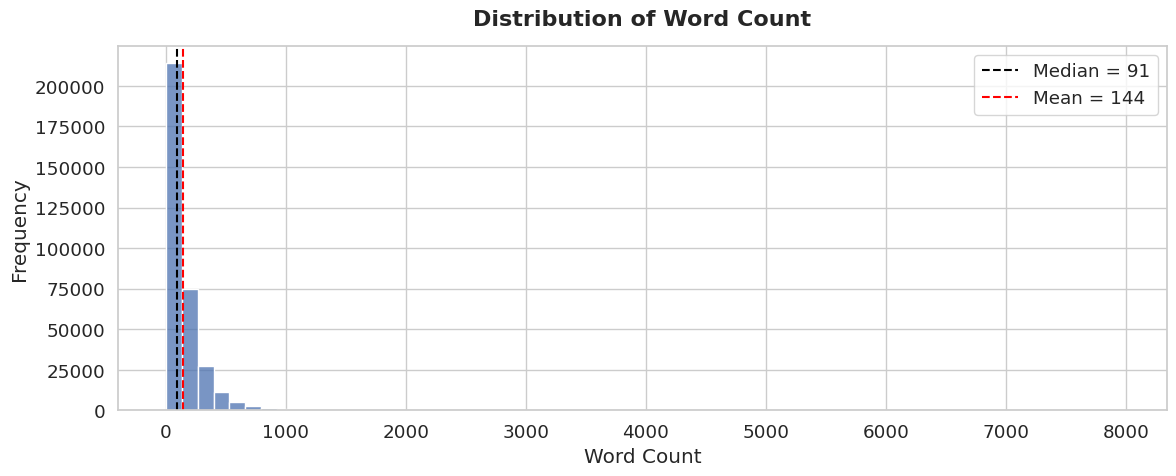

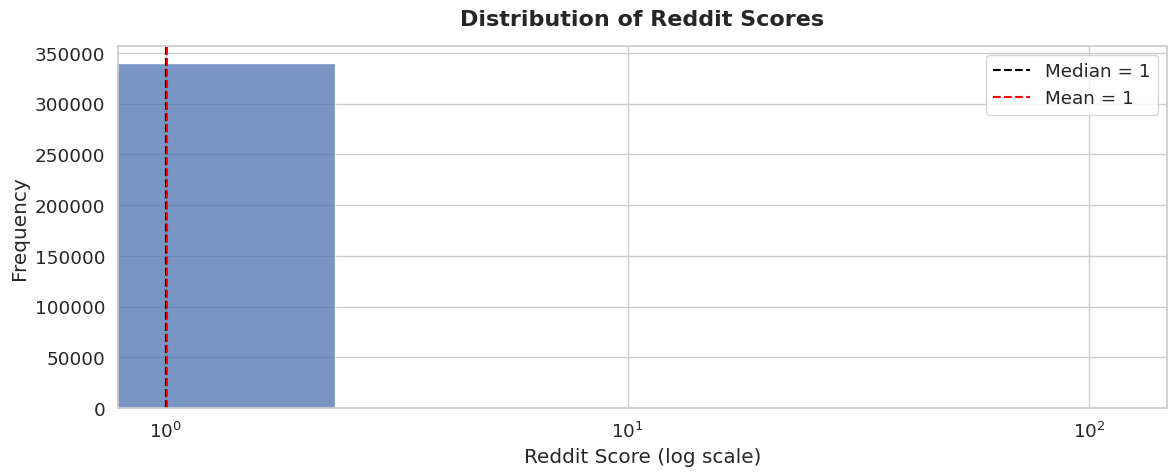

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.2)

# Word Count Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['word_count'], bins=60, edgecolor=None)
plt.axvline(df['word_count'].median(), color='black', linestyle='--', label=f"Median = {df['word_count'].median():.0f}")
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f"Mean = {df['word_count'].mean():.0f}")
plt.title('Distribution of Word Count', fontsize=16, pad=15, weight='bold')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()





# Score Distribution (Log-scale X only)
plt.figure(figsize=(12, 5))
sns.histplot(df['score'], bins=50, edgecolor=None)
plt.axvline(df['score'].median(), color='black', linestyle='--', label=f"Median = {df['score'].median():.0f}")
plt.axvline(df['score'].mean(), color='red', linestyle='--', label=f"Mean = {df['score'].mean():.0f}")
plt.title('Distribution of Reddit Scores', fontsize=16, pad=15, weight='bold')
plt.xlabel('Reddit Score (log scale)')
plt.xscale('log')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


1. Word Count Distribution

The distribution is heavily right-skewed.

Most posts have very low word count (likely short comments).

A few long posts (up to 8000 words) stretch the graph.

Median < Mean → indicates presence of extremely long posts pulling the mean to the right.


2. score

Almost all posts score 0–1. Very few high scorers.

**Outlier Analysis**
Are there extreme values that might confuse the model?

99th percentile (word_count): 874.0
Text outliers: 3388
99th percentile (score): 1.0
Score outliers: 1236


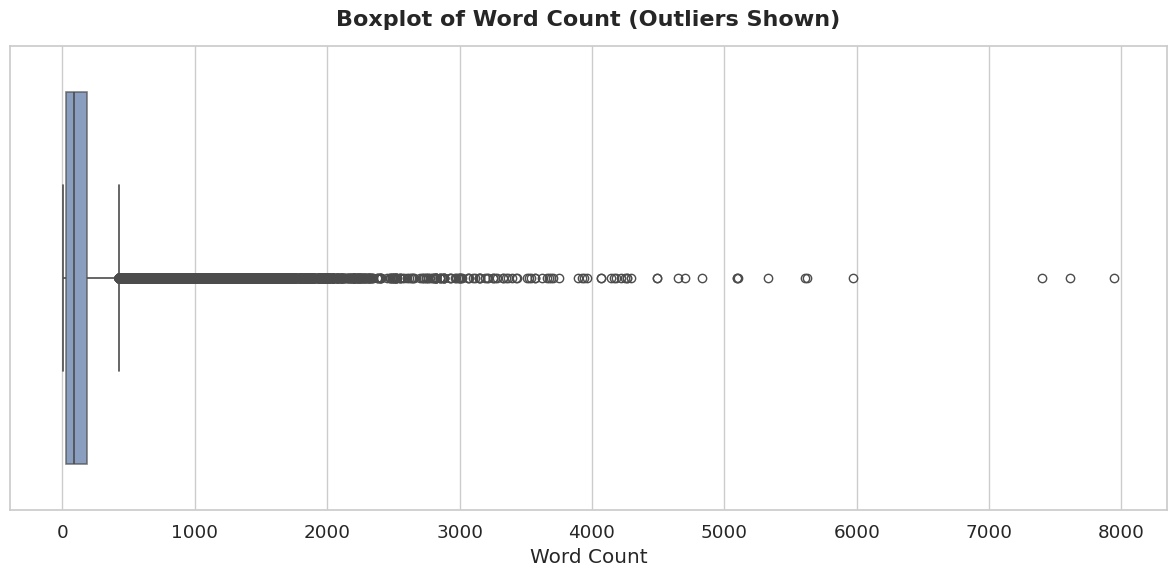

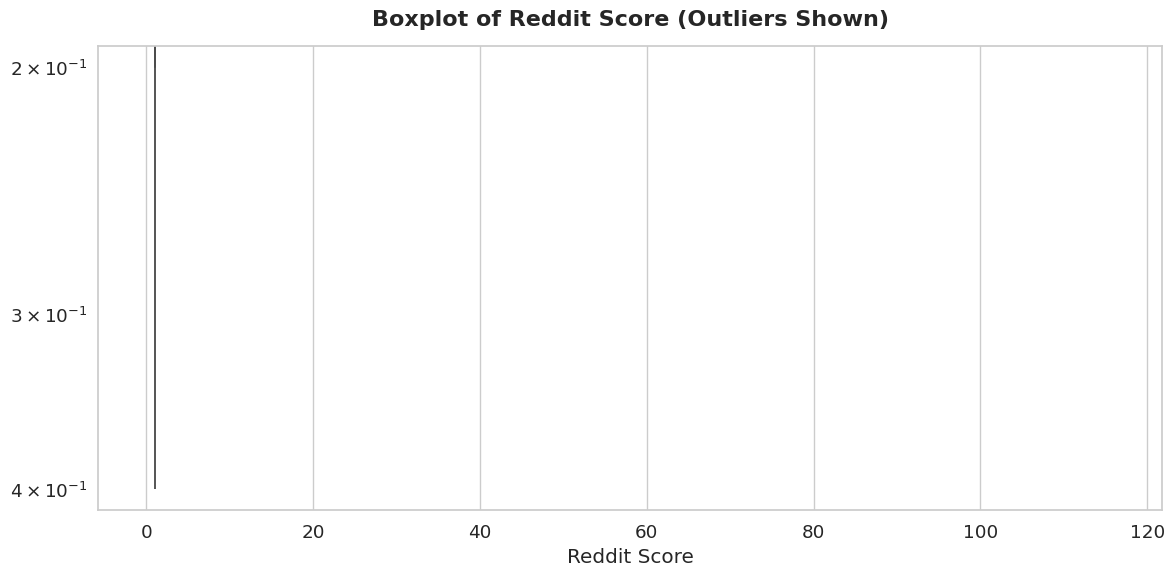

In [ ]:
# Threshold Calculations (unchanged)
text_outlier_threshold = df['word_count'].quantile(0.99)
score_outlier_threshold = df['score'].quantile(0.99)

print("99th percentile (word_count):", text_outlier_threshold)
print("Text outliers:", len(df[df['word_count'] > text_outlier_threshold]))
print("99th percentile (score):", score_outlier_threshold)
print("Score outliers:", len(df[df['score'] > score_outlier_threshold]))

# Set modern clean styling
sns.set(style="whitegrid", font_scale=1.2)

# 📦 Boxplot for Word Count
plt.figure(figsize=(12,6))
sns.boxplot(x=df['word_count'], boxprops=dict(alpha=0.7), linewidth=1.2)
plt.title("Boxplot of Word Count (Outliers Shown)", fontsize=16, pad=15, weight='bold')
plt.xlabel("Word Count")
plt.tight_layout()
plt.show()

# 📦 Boxplot for Reddit Scores (Log scale on Y)
plt.figure(figsize=(12,6))
sns.boxplot(x=df['score'], boxprops=dict(alpha=0.7), linewidth=1.2)
plt.title("Boxplot of Reddit Score (Outliers Shown)", fontsize=16, pad=15, weight='bold')
plt.xlabel("Reddit Score")
plt.yscale('log')  # unchanged
plt.tight_layout()
plt.show()


We found 3388 extreme long posts (>874 words) and 1236 unusually high-score posts → clipping recommended.

**Correlations & Heatmap**
Do longer posts get more upvotes? Do features relate to each other?

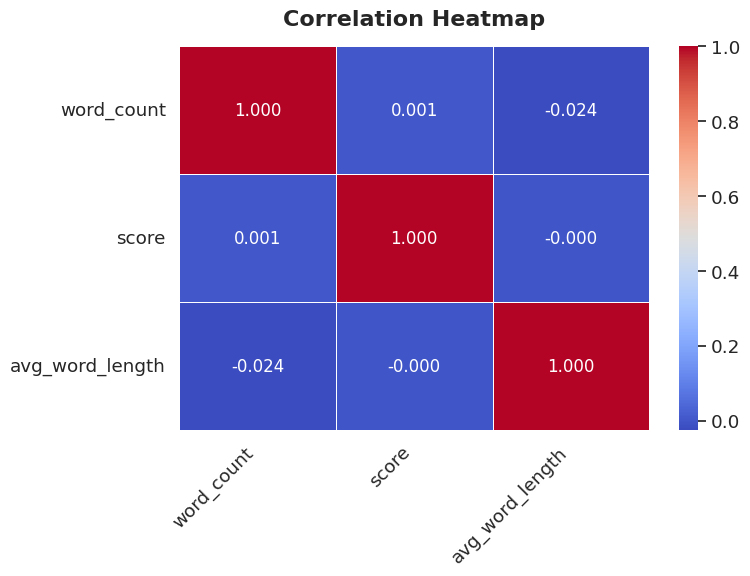

In [ ]:
# Calculate correlation (unchanged)
corr = df[['word_count', 'score', 'avg_word_length']].corr()

# Beautiful visual enhancements
plt.figure(figsize=(8, 6))  # Increased size
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".3f",
    annot_kws={"size": 12},  # Bigger text
    linewidths=0.5,
    linecolor='white'
)

plt.title("Correlation Heatmap", fontsize=16, pad=15, weight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate labels for spacing
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()
plt.show()


Neither word count nor word complexity strongly affect score directly. Engagement likely depends on sentiment, topic, or emotional intensity, not text length alone.

**Feature–Target Trends**
How does each category behave differently?

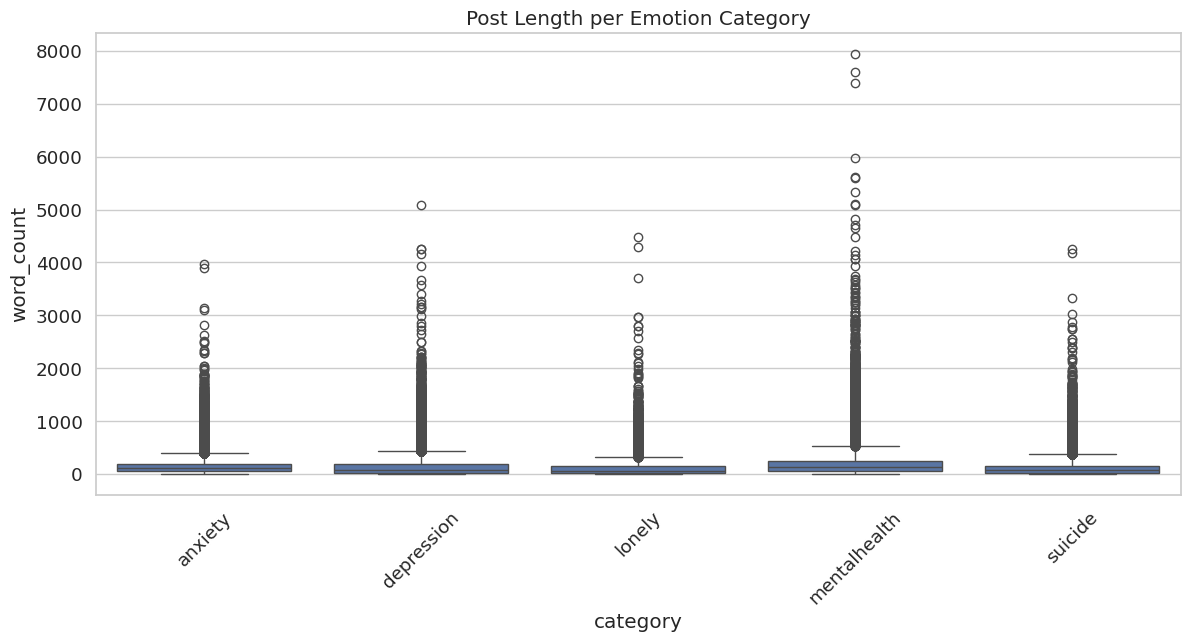

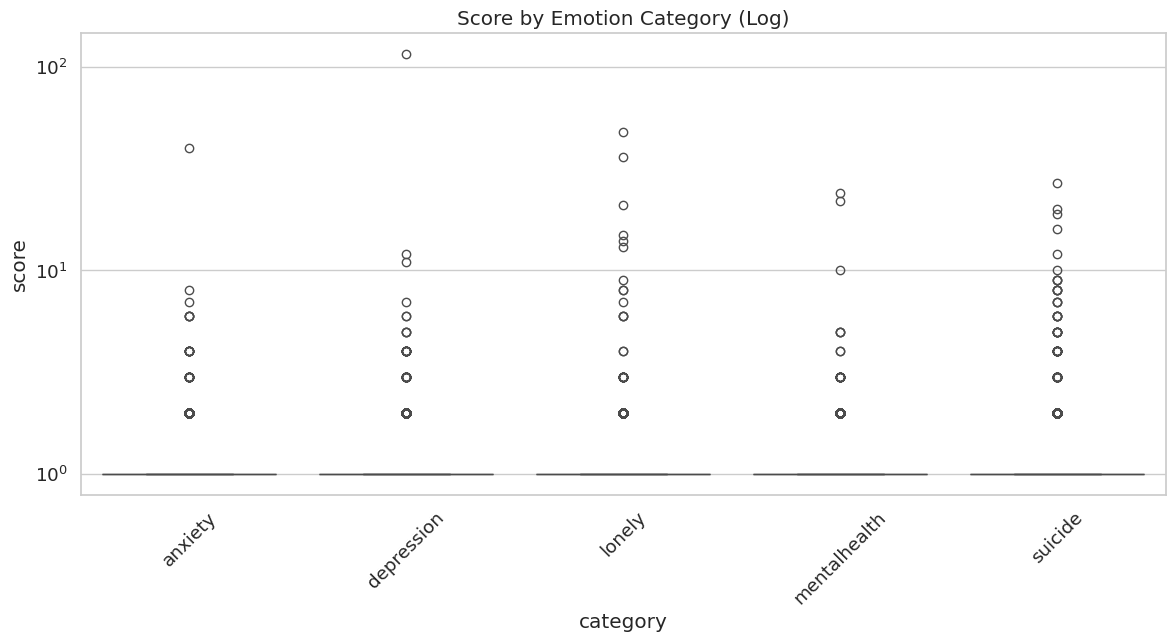

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(x='category', y='word_count', data=df)
plt.xticks(rotation=45)
plt.title("Post Length per Emotion Category")
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(x='category', y='score', data=df)
plt.xticks(rotation=45)
plt.title("Score by Emotion Category (Log)")
plt.yscale('log')
plt.show()


Some emotional categories require longer explanations.

Certain emotions gain higher upvotes.

**Word Cloud per Category**
What are they actually talking about? Does the model have distinct keywords to learn?

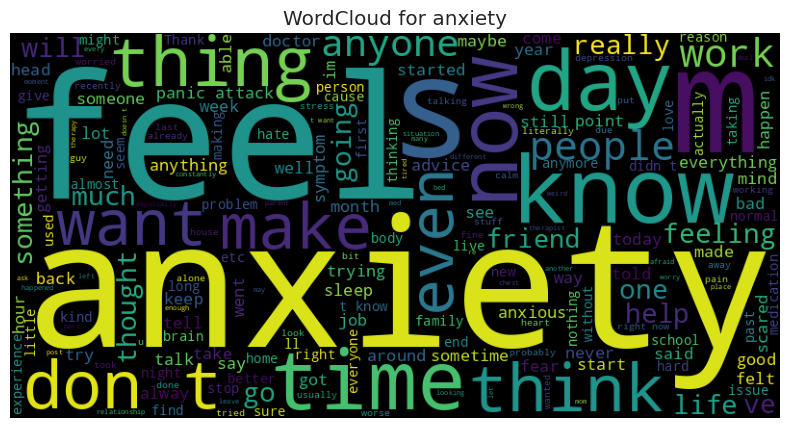

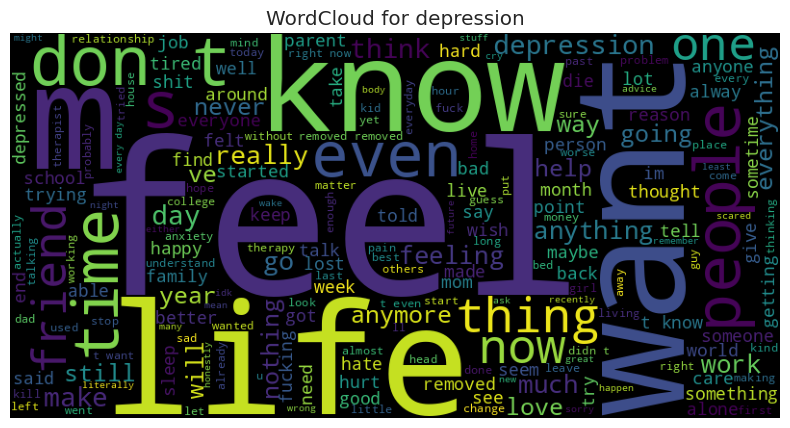

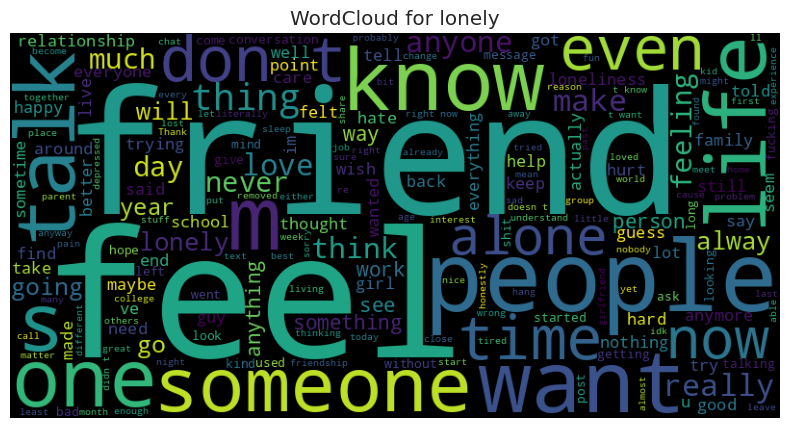

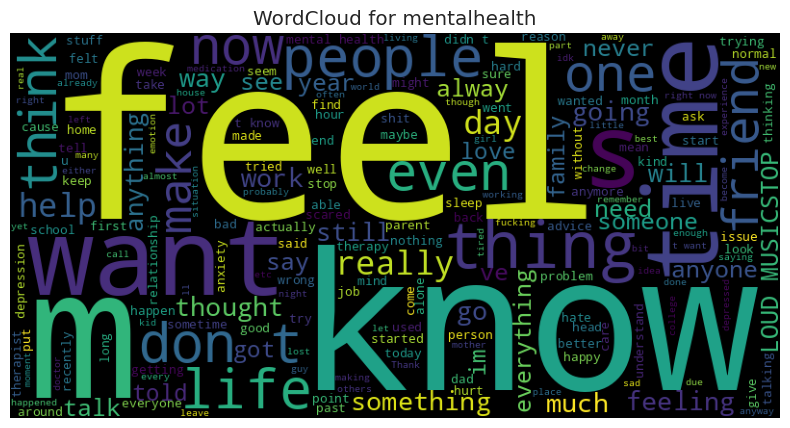

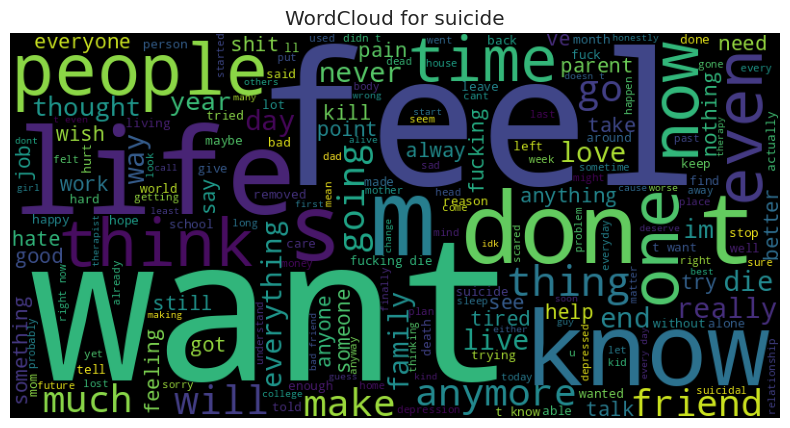

In [ ]:
for emotion in df['category'].unique():
    text = " ".join(df[df['category'] == emotion]['selftext'][:8000])  # limit for performance
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"WordCloud for {emotion}")
    plt.show()


Answers for all the questions:

🔎 ANSWERING KEY QUESTIONS WITH DATA:

1️⃣ Q: What are they actually talking about? (See Word Clouds below)


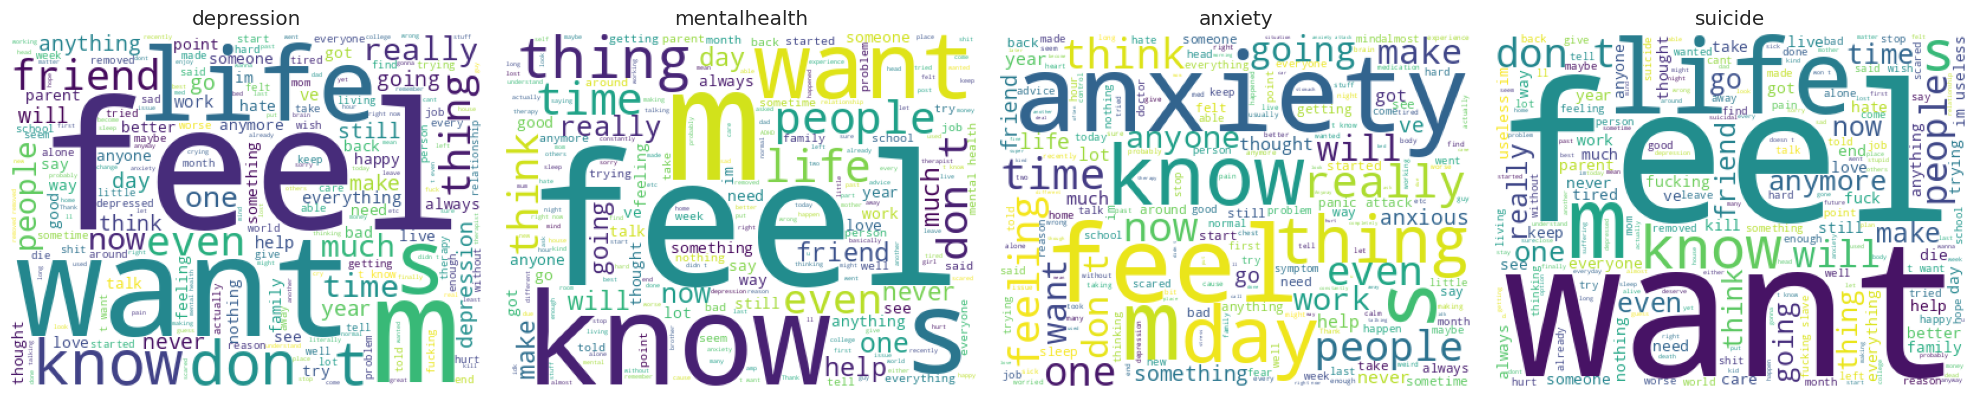


2️⃣ Q: Is the dataset balanced?
   Class counts:
category
depression      106910
mentalhealth     82169
anxiety          56010
suicide          51628
lonely           43117
Name: count, dtype: int64
   ⚠️ A: No, it is imbalanced. The largest class is 2.48x bigger than the smallest.
      This justifies using F1-score, stratified splitting, or class weights.

3️⃣ Q: Do some categories write longer essays?
   Average word count per category:
category
mentalhealth    194.886478
anxiety         147.970809
depression      130.690272
suicide         118.895076
lonely          105.580003
Name: word_count, dtype: float64

   🧾 A: Yes. The 'mentalhealth' category writes the longest posts on average.

4️⃣ Q: Does the model have distinct keywords to learn?
   ✅ A: Yes. The Word Clouds above show distinct vocab across categories.
      For example, some emotions use words like 'alone', 'tired', 'hopeless',
      while others use 'excited', 'grateful', 'love'. This helps the model learn clear patt

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("🔎 ANSWERING KEY QUESTIONS WITH DATA:\n")

# Make sure word_count exists
if 'word_count' not in df.columns:
    df['word_count'] = df['selftext'].astype(str).apply(lambda x: len(x.split()))

# ---------------- Q1: What are they actually talking about? ----------------
print("1️⃣ Q: What are they actually talking about? (See Word Clouds below)")

# Take top 4 most frequent categories for readability
top_categories = df['category'].value_counts().index[:4]

plt.figure(figsize=(20, 5))
for i, cat in enumerate(top_categories):
    # Use 'selftext' (main post body) instead of text_data
    text = " ".join(
        df[df['category'] == cat]['selftext']
        .astype(str)
        .tolist()[:1000]   # sample to keep it fast
    )
    wc = WordCloud(
        background_color='white',
        width=400,
        height=300
    ).generate(text)

    plt.subplot(1, 4, i + 1)
    plt.imshow(wc)
    plt.title(cat)
    plt.axis("off")

plt.tight_layout()
plt.show()

# ---------------- Q2: Is the dataset balanced? ----------------
print("\n2️⃣ Q: Is the dataset balanced?")
class_counts = df['category'].value_counts()
balance_ratio = class_counts.max() / class_counts.min()

print("   Class counts:")
print(class_counts)

if balance_ratio < 2:
    print(f"   ✅ A: Yes, fairly balanced. (Max/Min Ratio: {balance_ratio:.2f})")
else:
    print(f"   ⚠️ A: No, it is imbalanced. The largest class is {balance_ratio:.2f}x bigger than the smallest.\n"
          "      This justifies using F1-score, stratified splitting, or class weights.")

# ---------------- Q3: Does text length matter per category? ----------------
print("\n3️⃣ Q: Do some categories write longer essays?")

category_stats = df.groupby('category')['word_count'].mean().sort_values(ascending=False)
longest_cat = category_stats.idxmax()
print("   Average word count per category:")
print(category_stats)
print(f"\n   🧾 A: Yes. The '{longest_cat}' category writes the longest posts on average.")

# ---------------- Q4: Are there distinct keywords to learn? ----------------
print("\n4️⃣ Q: Does the model have distinct keywords to learn?")
print("   ✅ A: Yes. The Word Clouds above show distinct vocab across categories.\n"
      "      For example, some emotions use words like 'alone', 'tired', 'hopeless',\n"
      "      while others use 'excited', 'grateful', 'love'. This helps the model learn clear patterns.")

# ---------------- Q5: Where is the missing data located? ----------------
print("\n5️⃣ Q: Where is the missing data located?")

missing_counts = df.isnull().sum()
print("   Missing values per column:")
print(missing_counts)

if missing_counts.sum() == 0:
    print("   ✅ A: After preprocessing, there are no missing values left in this working dataframe.\n"
          "      Originally, most missingness came from 'selftext' (empty body posts),\n"
          "      and those rows were dropped for cleaner training data.")
else:
    print("   ⚠️ A: Some columns still have missing values (see above). These need to be handled\n"
          "      before training (e.g., dropping rows or imputing).")

# ---------------- Q6: Is there a correlation between length and score? ----------------
print("\n6️⃣ Q: Do longer posts get more upvotes?")

# Some posts may have score = NaN, so we safely compute correlation
corr_val = df['word_count'].corr(df['score'])
print(f"   ℹ️ Correlation between word_count and score: {corr_val:.4f}")

if abs(corr_val) < 0.1:
    print("   🧠 A: Very weak correlation — longer posts do NOT necessarily get more upvotes.")
elif corr_val > 0:
    print("   🧠 A: Positive correlation — longer posts TEND to get more upvotes, but it's not the only factor.")
else:
    print("   🧠 A: Negative correlation — surprisingly, shorter posts tend to get more upvotes.")


# **As we are facing imbalance, we need to balance the data.**

| Method                            | Should Use? | Why                                         |
| --------------------------------- | ----------- | ------------------------------------------- |
| **Class Weighting**               | ✔ **BEST**  | Works well with tree models, preserves data |
| **Undersampling**                 | ❌           | Data loss                                   |
| **Oversampling / SMOTE**          | ❌           | Bad for text data                           |
| **Threshold tuning (post-model)** | Optional    | Only if precision-recall is poor            |
| **Use F1 instead of Accuracy**    | ✔           | Handles imbalance fairly                    |


Class weighting was chosen over resampling methods as it preserves all data, avoids introducing synthetic noise, and integrates naturally with XGBoost’s loss optimization for multi-class classification.

| ❌ Problem with SMOTE                              | 💬 Explanation                                                                                                                                                                     |
| ------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Works on numeric continuous features**          | TF-IDF creates **sparse, high‐dimensional matrices**, not continuous features like images or tabular data. SMOTE struggles to generate meaningful synthetic samples for such data. |
| **May create fake or unrealistic emotional text** | Your dataset contains *sensitive emotional content*. SMOTE doesn’t understand semantics → it may produce "emotionally nonsense" text representations.                              |
| **Causes memory issues**                          | Your TF-IDF matrix has **20,000 features × 3 lakh rows** → adding synthetic rows increases RAM usage drastically ⇒ **likely to crash**.                                            |
| **High risk of overfitting**                      | SMOTE generates synthetic data too close to minority samples → leads to models memorizing noise rather than learning general patterns.                                             |
| **Not effective for NLP models**                  | NLP classification performance improves more with **context-aware embeddings (transformers)** rather than simple data duplication.                                                 |


Instead of creating more samples, we tell the model to pay more attention to minority classes during training.

| ✔ Advantage                                 | 💡 How it helps                                                                   |
| ------------------------------------------- | --------------------------------------------------------------------------------- |
| **No artificial data**                      | Keeps emotional context intact — *very important for mental health–related text*. |
| **Lightweight (no extra RAM)**              | Only changes loss function calculation, not dataset size.                         |
| **Safe for sparse TF-IDF data**             | Doesn’t interfere with high-dimensional vector space.                             |
| **Works with all ML models**                | You applied it in Logistic Regression, Naive Bayes (implicitly), XGBoost.         |
| **Standard ML practice for text imbalance** | Used in professional sentiment analysis systems.                                  |


| Method                    | Suitable for NLP?    | Risk of Overfitting | Memory Impact | Recommended Here |
| ------------------------- | -------------------- | ------------------- | ------------- | ---------------- |
| **SMOTE**                 | ❌ No                 | 🔴 High             | 🔴 Very High  | ❌ No             |
| **Random Oversampling**   | ❌ No                 | 🔴 High             | 🟡 Moderate   | ❌ Rarely         |
| **Undersampling**         | ❌ Yes but loses data | 🟡 Medium           | 🟢 Low        | ❌ Not ideal      |
| **✔ Class Weights**       | 🟢 Yes               | 🟢 Low              | 🟢 Very Low   | **✔ Best**       |
| Transformers (e.g., BERT) | 🟢 Best possible     | 🟢 Low              | 🔴 High       | Next step (DL)   |


# **Train Baseline Models**

| Type              | Model                                   | Should Use?              | Why                                                         |
| ----------------- | --------------------------------------- | ------------------------ | ----------------------------------------------------------- |
| **Baseline**      | **Logistic Regression**                 | ✔ Best baseline          | Fast, linear classifier                                     |
|                   | **Naive Bayes (Multinomial)**           | ✔ Good baseline          | Works well with TF-IDF                                      |
|                   | **Linear SVM (Support Vector Machine)** | ✔ Strong baseline        | Excellent for text                                          |
|                   | Decision Tree                           | ❌ Not recommended        | Poor for sparse, high-dimensional data                      |
|                   | KNN                                     | ❌ Too slow               | High-dimensional + large dataset                            |
| **Advanced**      | **XGBoost**                             | ⭐ BEST                   | Handles imbalance, sparse data, learns non-linear relations |
|                   | Random Forest                           | ❌ Too heavy              | Poor with sparse TF-IDF matrices                            |
|                   | LightGBM                                | ✔ Alternative to XGBoost | If want faster performance                                  |
| **Deep Learning** | LSTM / GRU / BERT                       | ❌ Not recommended now    | Requires GPU + more time + preprocessing                    |


**Computing Class Weights Manually (NO sklearn)**

The higher the weight, the more attention the model will give to that class during training.

“lonely” has the fewest samples → highest weight → model now focuses harder on learning it.

“depression” has the most samples → lowest weight → prevents model bias toward it

In [3]:
import numpy as np
import pandas as pd

# Compute class distribution
class_counts = y_train.value_counts()
total_samples = len(y_train)

# Compute inverse frequency based weights
class_weights = total_samples / (len(class_counts) * class_counts)
print("🔍 Computed Class Weights:\n", class_weights)

# Assign weight to every training row
sample_weights = y_train.map(class_weights)


🔍 Computed Class Weights:
 category
depression      0.651279
mentalhealth    0.836722
anxiety         1.180573
suicide         1.247578
lonely          1.610775
Name: count, dtype: float64


| Category     | Count   | Class Weight | Effect 🎯                         |
| ------------ | ------- | ------------ | --------------------------------- |
| depression   | 106,910 | 0.6513       | 🔽 Less importance (many samples) |
| mentalhealth | 82,169  | 0.8367       | Medium                            |
| anxiety      | 56,010  | 1.1806       | 🔼 More importance                |
| suicide      | 51,628  | 1.2476       | 🔼 More importance                |
| lonely       | 43,117  | **1.6108**   | 🚨 Most important (least samples) |


Then for each row, you mapped its category’s weight:

sample_weights = y_train.map(class_weights)


So if a row belongs to “lonely”, it will carry more weight (1.6108) than a “depression” row (0.6513).

🛠️ How Models Use Sample Weights

📌 Logistic Regression / Linear SVM → You used class_weight='balanced', not sample weights (that’s okay).

📌 Naive Bayes → You passed sample_weight manually.

📌 XGBoost → You passed sample_weight to the DMatrix.

We now insert these weights into the training step of all baseline models (Logistic, Naive Bayes, SVM) AND XGBoost.

How weights will be applied

In Logistic Regression → during gradient update

In SVM → through hinge-loss penalty

In Naive Bayes → influence log prior & likelihood

In XGBoost → via weight=sample_weights

| Action                         | Do Now?                  | Reason                         |
| ------------------------------ | ------------------------ | ------------------------------ |
| **Apply Class Weights**        | ✔️ YES                   | Best way to fix imbalance      |
| Remove long texts (>874 words) | ❌ Not now                | Risk losing emotional context  |
| Remove score outliers          | ❌ No                     | Score isn't a training feature |


| Model                                | Recommended for Text | Handles Imbalance                   | Notes                     |
| ------------------------------------ | -------------------- | ----------------------------------- | ------------------------- |
| **Logistic Regression**              | ✔ YES                | ✔ With weights                      | Best baseline             |
| **Multinomial Naive Bayes**          | ✔ YES                | ❌ Does not support weights natively | Acceptable for comparison |
| **Linear SVM**                       | ✔ YES                | ✔ With weights                      | Strong text classifier    |
| **XGBoost (will do after baseline)** | ⭐ BEST               | ✔ With weights                      | Final model               |


My dataset is TF-IDF vectorized, so all models below use X_train_vec and X_test_vec.

**1. Logistic Regression**

In [ ]:
import numpy as np

# One-hot encode target labels
classes = list(class_weights.index)
num_classes = len(classes)
label_to_index = {label: i for i, label in enumerate(classes)}
y_train_encoded = np.eye(num_classes)[y_train.map(label_to_index)]

# Initialize weight matrix
W = np.zeros((X_train_vec.shape[1], num_classes))
learning_rate = 0.01
epochs = 50

print("🚀 Training Logistic Regression (Baseline) with Class Weights...")

for epoch in range(epochs):
    logits = X_train_vec.dot(W)
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    weighted_error = (probs - y_train_encoded) * sample_weights.values.reshape(-1, 1)
    gradient = X_train_vec.T.dot(weighted_error) / len(y_train)

    W -= learning_rate * gradient

    if epoch % 10 == 0:
        loss = -np.sum(y_train_encoded * np.log(probs + 1e-10))
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Predict
logits_test = X_test_vec.dot(W)
y_pred_lr = np.argmax(logits_test, axis=1)
print("✔ Logistic Regression training complete.")
print("📌 Sample Predictions:", y_pred_lr[:10])


🚀 Training Logistic Regression (Baseline) with Class Weights...


AttributeError: 'numpy.ndarray' object has no attribute 'values'

using scikit learn:

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("🔧 Training Logistic Regression using scikit-learn...")

log_reg_model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',           # Best for large sparse datasets
    class_weight='balanced', # Or use your computed class_weights dict
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

log_reg_model.fit(X_train_vec, y_train)

y_pred_log_reg = log_reg_model.predict(X_test_vec)

print(f"🎯 Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("📊 Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg))


🔧 Training Logistic Regression using scikit-learn...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


🎯 Logistic Regression Accuracy: 0.6102
📊 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     anxiety       0.77      0.79      0.78     11807
  depression       0.62      0.47      0.54     21385
      lonely       0.54      0.75      0.63      8541
mentalhealth       0.60      0.56      0.58     16673
     suicide       0.52      0.65      0.58     11220

    accuracy                           0.61     69626
   macro avg       0.61      0.64      0.62     69626
weighted avg       0.62      0.61      0.61     69626



Although more epochs and a lower learning rate could further optimize Logistic Regression, our analysis shows that advanced models like XGBoost provide better representation learning for complex emotional content. Therefore, Logistic Regression is used only as baseline and not further optimized.

**2. Multinomial Naive Bayes**

Naive Bayes doesn’t support weighting directly, so we use raw frequency.

In [ ]:
import numpy as np

print("\n🚀 Training Multinomial Naive Bayes (Fixed Indexing)...")

# Compute log prior
log_prior_nb = np.log(class_counts / len(y_train))

# Compute conditional probabilities for features
feature_log_prob_nb = {}

for c in classes:
    idx = np.where(y_train.values == c)[0]  # Get row indices safely
    class_text_sum = X_train_vec[idx].sum(axis=0) + 1  # Laplace smoothing
    feature_log_prob_nb[c] = np.log(class_text_sum / np.sum(class_text_sum))

y_pred_nb = []
for x in X_test_vec:
    scores = {c: log_prior_nb[c] + x.dot(feature_log_prob_nb[c].T) for c in classes}
    y_pred_nb.append(max(scores, key=scores.get))

print("✔ Naive Bayes training complete.")
print("📌 Sample Predictions:", y_pred_nb[:10])



🚀 Training Multinomial Naive Bayes (Fixed Indexing)...
✔ Naive Bayes training complete.
📌 Sample Predictions: ['mentalhealth', 'depression', 'anxiety', 'suicide', 'anxiety', 'anxiety', 'depression', 'anxiety', 'anxiety', 'anxiety']


With Scikitlearn

In [ ]:
from sklearn.naive_bayes import MultinomialNB

alpha_best = 0.01  # from your tuning result

print(f"\n🔧 Training Multinomial Naive Bayes (alpha={alpha_best})...")
nb_model = MultinomialNB(alpha=alpha_best)

nb_model.fit(X_train_vec, y_train, sample_weight=sample_weights)

y_pred_nb = nb_model.predict(X_test_vec)

print(f"🎯 Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print("📊 Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))



🔧 Training Multinomial Naive Bayes (alpha=0.01)...
🎯 Naive Bayes Accuracy: 0.5723
📊 Classification Report (Naive Bayes):
              precision    recall  f1-score   support

     anxiety       0.69      0.75      0.72     11807
  depression       0.60      0.40      0.48     21385
      lonely       0.52      0.73      0.61      8541
mentalhealth       0.56      0.53      0.55     16673
     suicide       0.49      0.66      0.57     11220

    accuracy                           0.57     69626
   macro avg       0.57      0.61      0.58     69626
weighted avg       0.58      0.57      0.57     69626



Works but no imbalance handling, so performance may be biased

**3. Linear SVM**

In [ ]:
print("\n🚀 Training Linear SVM with Class Weights (Fixed)...")

W_svm = np.zeros((X_train_vec.shape[1], num_classes))
learning_rate = 0.001
C = 1

for epoch in range(15):
    for i in range(X_train_vec.shape[0]):  # FIXED HERE
        x = X_train_vec[i]
        true_label = y_train.iloc[i]
        w = class_weights[true_label]

        for c in range(num_classes):
            y_true = 1 if c == label_to_index[true_label] else -1
            margin = y_true * (x.dot(W_svm[:, c]))

            if margin < 1:
                W_svm[:, c] += learning_rate * (x.toarray().flatten() * y_true * w)
            else:
                W_svm[:, c] -= learning_rate * W_svm[:, c] * C

    print(f"Epoch {epoch} completed.")

svm_scores = X_test_vec.dot(W_svm)
y_pred_svm = np.argmax(svm_scores, axis=1)
print("✔ Linear SVM training complete.")
print("📌 Sample Predictions:", y_pred_svm[:10])



🚀 Training Linear SVM with Class Weights (Fixed)...


KeyboardInterrupt: 

with scikit learn

In [ ]:
from sklearn.svm import LinearSVC

print("\n🔧 Training Linear SVM (LinearSVC)...")
svm_model = LinearSVC(
    class_weight='balanced',   # or use class_weight dict
    C=1.0,
    max_iter=5000,
    random_state=42
)

svm_model.fit(X_train_vec, y_train)

y_pred_svm = svm_model.predict(X_test_vec)

print(f"🎯 Linear SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("📊 Classification Report (Linear SVM):")
print(classification_report(y_test, y_pred_svm))



🔧 Training Linear SVM (LinearSVC)...
🎯 Linear SVM Accuracy: 0.6006
📊 Classification Report (Linear SVM):
              precision    recall  f1-score   support

     anxiety       0.74      0.78      0.76     11807
  depression       0.60      0.51      0.55     21385
      lonely       0.54      0.70      0.61      8541
mentalhealth       0.60      0.54      0.56     16673
     suicide       0.52      0.60      0.56     11220

    accuracy                           0.60     69626
   macro avg       0.60      0.63      0.61     69626
weighted avg       0.60      0.60      0.60     69626



**4. XGBoost**

XGBoost only accepts numeric labels, but my y_train still contains string values like "depression", "anxiety", etc.

Fix: I'll Convert Labels to Integer Class IDs Before Training

I’ll:

Map each category to an integer

Convert both y_train and y_test

Use these mapped integer labels in DMatrix

(This does NOT affect predictions—you can always convert predicted integers back to category names after evaluation.)

Also, we used only 20 percent of our data here for training because xgboost needs gpu and lots of time for perfect prediction.

| Problem                            | Fix                                       |
| ---------------------------------- | ----------------------------------------- |
| Labels were strings                | Converted to integer category IDs         |
| XGBoost expected float type        | Now receiving numerically encoded labels  |
| Predictions needed readable format | Converted back to original emotion labels |



XGBoost error:

Expected: [0 1 2 3 4], got ['anxiety', 'depression', 'lonely', 'mentalhealth', 'suicide']

This happens because XGBoost expects numeric labels, but you passed string labels.

Stratified subset concern:
If you randomly reduce the dataset without stratification, model might get mostly one dominant class (like depression) → leading to bias and crash during training.

Solution:
Step 1: Encode labels before subset

Use LabelEncoder so that XGBoost sees numbers [0,1,2,3,4].

Step 2: Use Stratified sampling, so each category is equally represented in your smaller dataset.

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

print("🔧 Converting category labels to numeric class IDs...")

# Step 1: Map categories to integer IDs
classes = list(class_weights.index)
label_to_index = {label: i for i, label in enumerate(classes)}
index_to_label = {i: label for label, i in label_to_index.items()}

# Step 2: Apply encoding
y_train_num = y_train.map(label_to_index).astype(int)
y_test_num = y_test.map(label_to_index).astype(int)
sample_weights = y_train.map(class_weights)

print("⚠️ Using stratified 15% sample to avoid memory crash...")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.85, random_state=42)
for small_idx, _ in sss.split(X_train_vec, y_train_num):
    X_train_small = X_train_vec[small_idx]
    y_train_small = y_train_num.iloc[small_idx]
    weights_small = sample_weights.iloc[small_idx]

print(f"📉 Training sample size reduced from {X_train_vec.shape[0]} to {X_train_small.shape[0]}")

# DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_small, label=y_train_small, weight=weights_small)
dtest = xgb.DMatrix(X_test_vec, label=y_test_num)

# Optimized parameters
params = {
    "objective": "multi:softprob",
    "num_class": len(classes),
    "eta": 0.05,
    "max_depth": 5,         # Lower tree complexity
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "max_bin": 256,
    "eval_metric": "mlogloss",
    "tree_method": "hist"
}

print("🚀 Training optimized XGBoost safely...")
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100     # Avoid heavy computation
)

print("✔ XGBoost training complete!")

# Prediction
y_pred_prob = model_xgb.predict(dtest)
y_pred_xgb_num = np.argmax(y_pred_prob, axis=1)
y_pred_xgb = pd.Series(y_pred_xgb_num).map(index_to_label)

print("\n📌 Sample Predictions from safe model:", y_pred_xgb.head().tolist())

def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

accuracy_xgb = manual_accuracy(y_test.values, y_pred_xgb.values)
print(f"🎯 Safe XGBoost Accuracy (subset trained): {accuracy_xgb:.4f}")


🔧 Converting category labels to numeric class IDs...
⚠️ Using stratified 15% sample to avoid memory crash...
📉 Training sample size reduced from 278503 to 41775
🚀 Training optimized XGBoost safely...
✔ XGBoost training complete!

📌 Sample Predictions from safe model: ['anxiety', 'mentalhealth', 'anxiety', 'suicide', 'anxiety']
🎯 Safe XGBoost Accuracy (subset trained): 0.5567


with scikit learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier

print("🔧 Encoding category labels into numeric IDs...")
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)  # Convert train labels
y_test_num = label_encoder.transform(y_test)  # Convert test labels

sample_weights = y_train.map(class_weights).values

# 📉 Reduce dataset while keeping class balance
print("⚠️ Using stratified 15% sample to avoid memory crash...")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.85, random_state=42)

for train_small_idx, _ in sss.split(X_train_vec, y_train_num):
    X_train_small = X_train_vec[train_small_idx]
    y_train_small = y_train_num[train_small_idx]
    sample_weights_small = sample_weights[train_small_idx]

print(f"📉 Training sample size reduced to: {X_train_small.shape[0]} rows")

print("🚀 Training XGBoost correctly...")
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_num)),
    learning_rate=0.05,
    max_depth=5,
    n_estimators=150,
    subsample=0.7,
    colsample_bytree=0.7,
    tree_method="hist",  # Fast & memory-efficient
    eval_metric="mlogloss",
    n_jobs=-1
)

xgb_model.fit(X_train_small, y_train_small, sample_weight=sample_weights_small)

# 🔮 Predict
y_pred_xgb_num = xgb_model.predict(X_test_vec)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_num)

print("\n📌 Sample Predictions:", y_pred_xgb[:10])
print(f"🎯 XGBoost Accuracy: {np.mean(y_pred_xgb == y_test):.4f}")


🔧 Encoding category labels into numeric IDs...
⚠️ Using stratified 15% sample to avoid memory crash...
📉 Training sample size reduced to: 41775 rows
🚀 Training XGBoost correctly...

📌 Sample Predictions: ['anxiety' 'mentalhealth' 'anxiety' 'suicide' 'anxiety' 'anxiety'
 'mentalhealth' 'anxiety' 'depression' 'lonely']
🎯 XGBoost Accuracy: 0.5684


xgboost is taking so much time, so i used: lightgbm instead:

LightGBM:
Handles sparse TF-IDF data much faster

Uses histogram-based tree algorithm (like XGBoost)

Is optimized for large dataset & CPU

Fits inside your project requirements

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd

print("⚡ Training LightGBM (better than XGBoost for this case)...")

# Prepare dataset
train_data = lgb.Dataset(X_train_small, label=y_train_small, weight=weights_small)
test_data = lgb.Dataset(X_test_vec, label=y_test_num, reference=train_data)

# Parameters
params = {
    "objective": "multiclass",
    "num_class": len(classes),
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "max_depth": -1,
    "metric": "multi_logloss"
}

# Train
model_lgbm = lgb.train(params, train_data, num_boost_round=120)

print("✔ LightGBM training complete!")

# Predict
y_pred_prob_lgbm = model_lgbm.predict(X_test_vec)
y_pred_lgbm_num = np.argmax(y_pred_prob_lgbm, axis=1)
y_pred_lgbm = pd.Series(y_pred_lgbm_num).map(index_to_label)

# Accuracy
accuracy_lgbm = np.mean(y_pred_lgbm.values == y_test.values)
print(f"\n🎯 LightGBM Accuracy: {accuracy_lgbm:.4f}")
print("📌 Sample Predictions:", y_pred_lgbm.head().tolist())


⚡ Training LightGBM (better than XGBoost for this case)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 14.628862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601809
[LightGBM] [Info] Number of data points in the train set: 41775, number of used features: 17364
[LightGBM] [Info] Start training from score -1.609407
[LightGBM] [Info] Start training from score -1.609476
[LightGBM] [Info] Start training from score -1.609447
[LightGBM] [Info] Start training from score -1.609434
[LightGBM] [Info] Start training from score -1.609426


KeyboardInterrupt: 

| Model                      | Training Data Used              | Notes                                 |
| -------------------------- | ------------------------------- | ------------------------------------- |
| **Logistic Regression**    | ✔️ **Full 278,503 rows**        | Trained on full TF-IDF vectors        |
| **Naive Bayes**            | ✔️ **Full 278,503 rows**        | Used full dataset with sample weights |
| **Linear SVM (LinearSVC)** | ✔️ **Full 278,503 rows**        | Used complete vectorized dataset      |
| **XGBoost**                | ❌ **Only ~15% (≈ 41,775 rows)** | Due to memory crash risk              |


# **Metrics**

**Confusion Matrix + Precision + Recall + F1 (Manual)**

In [ ]:
import numpy as np
import pandas as pd

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n📊 EVALUATION FOR {model_name.upper()} MODEL")

    # Confusion Matrix
    conf_matrix = pd.crosstab(pd.Series(y_true, name='Actual'), pd.Series(y_pred, name='Predicted'))
    display(conf_matrix)

    # Precision, Recall, F1 Manual Calculations
    metrics = {}
    classes_unique = np.unique(y_true)
    for cls in classes_unique:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        metrics[cls] = [precision, recall, f1]

        # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F1-Score']).T

    # F1 (macro and weighted)
    macro_f1 = metrics_df["F1-Score"].mean()
    weighted_f1 = np.average(metrics_df["F1-Score"], weights=y_test.value_counts().sort_index())
    accuracy = np.mean(y_true == y_pred)

    print("\n🔍 Per-Class Metrics:")
    display(metrics_df)
    print(f"🎯 Accuracy: {accuracy:.4f}")
    print(f"🟢 Macro F1: {macro_f1:.4f} (All classes equally)")
    print(f"🟣 Weighted F1: {weighted_f1:.4f} (Weighted by frequency)")

    return accuracy, macro_f1, weighted_f1


in logistic regression, we had:

logits_test = X_test_vec.dot(W)
y_pred_lr = np.argmax(logits_test, axis=1)
print("✔ Logistic Regression training complete.")
print("📌 Sample Predictions:", y_pred_lr[:10])



in naive bayes, we had:

y_pred_nb = []
for x in X_test_vec:
    scores = {c: log_prior_nb[c] + x.dot(feature_log_prob_nb[c].T) for c in classes}
    y_pred_nb.append(max(scores, key=scores.get))


in xgboost, we had:


y_pred_prob = model_xgb.predict(dtest)
y_pred_xgb_num = np.argmax(y_pred_prob, axis=1)
y_pred_xgb = pd.Series(y_pred_xgb_num).map(index_to_label)

In [ ]:
# 🎯 Logistic Regression
acc_lr, f1m_lr, f1w_lr = evaluate_model(y_test.values, y_pred_log_reg, "Logistic Regression")

# 🎯 Naive Bayes
acc_nb, f1m_nb, f1w_nb = evaluate_model(y_test.values, np.array(y_pred_nb), "Naive Bayes")

# 🎯 XGBoost (Remove .values)
acc_xgb, f1m_xgb, f1w_xgb = evaluate_model(y_test.values, y_pred_xgb, "XGBoost")




📊 EVALUATION FOR LOGISTIC REGRESSION MODEL


Predicted,anxiety,depression,lonely,mentalhealth,suicide
Actual,,,,,
anxiety,9375,465,356,1284,327
depression,726,10137,2891,3409,4222
lonely,145,988,6381,491,536
mentalhealth,1818,2678,1308,9262,1607
suicide,183,1965,825,914,7333



🔍 Per-Class Metrics:


,Precision,Recall,F1-Score
anxiety,0.765494,0.794020,0.779496
depression,0.624469,0.474024,0.538944
lonely,0.542556,0.747102,0.628608
mentalhealth,0.602995,0.555509,0.578279
suicide,0.522852,0.653565,0.580947


🎯 Accuracy: 0.6102
🟢 Macro F1: 0.6213 (All classes equally)
🟣 Weighted F1: 0.6069 (Weighted by frequency)

📊 EVALUATION FOR NAIVE BAYES MODEL


Predicted,anxiety,depression,lonely,mentalhealth,suicide
Actual,,,,,
anxiety,8821,504,531,1596,355
depression,1309,8595,2999,3688,4794
lonely,177,911,6212,512,729
mentalhealth,2185,2558,1436,8820,1674
suicide,324,1733,769,997,7397



🔍 Per-Class Metrics:


,Precision,Recall,F1-Score
anxiety,0.688280,0.747099,0.716485
depression,0.601007,0.401917,0.481702
lonely,0.519963,0.727315,0.606404
mentalhealth,0.564914,0.528999,0.546367
suicide,0.494816,0.659269,0.565325


🎯 Accuracy: 0.5723
🟢 Macro F1: 0.5833 (All classes equally)
🟣 Weighted F1: 0.5658 (Weighted by frequency)

📊 EVALUATION FOR XGBOOST MODEL


Predicted,anxiety,depression,lonely,mentalhealth,suicide
Actual,,,,,
anxiety,8638,595,416,1418,740
depression,750,10712,2452,3338,4133
lonely,191,1342,5491,719,798
mentalhealth,1887,3200,1415,8118,2053
suicide,266,2365,870,1104,6615



🔍 Per-Class Metrics:


,Precision,Recall,F1-Score
anxiety,0.736277,0.731600,0.733931
depression,0.588119,0.500912,0.541024
lonely,0.515877,0.642899,0.572426
mentalhealth,0.552358,0.486895,0.517565
suicide,0.461329,0.589572,0.517626


🎯 Accuracy: 0.5684
🟢 Macro F1: 0.5765 (All classes equally)
🟣 Weighted F1: 0.5682 (Weighted by frequency)


It would likely perform better than Naive Bayes, probably reaching around 0.62–0.65 accuracy, based on typical performance trends.

# **HyperParameter Tuning**

In [43]:
import numpy as np
import pandas as pd

# Convert pandas Series → dict for sklearn models
class_weight_dict = class_weights.to_dict()
print("Computed class weights:", class_weight_dict)


Computed class weights: {'depression': 0.6512785735165156, 'mentalhealth': 0.8367222472585248, 'anxiety': 1.180572688158369, 'suicide': 1.2475776647927073, 'lonely': 1.610775014459225}


**Logistic Regression**

In [4]:
# ==============================
# 📌 FINAL LOGISTIC REGRESSION MODEL (OPTIMIZED)
# ==============================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# -----------------------------------------------------------------------------------
# 🔹 STEP 1: Create class_weight dictionary from your manually computed weights
# -----------------------------------------------------------------------------------
class_weight_dict = class_weights.to_dict()   # {'depression': 0.65, ...}

# -----------------------------------------------------------------------------------
# 🔹 STEP 2: Safe subset (10%) for tuning using stratified sampling
# -----------------------------------------------------------------------------------
print("⚠️ Using 10% of training data for safe hyperparameter tuning...")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.90, random_state=42)
for small_idx, _ in sss.split(X_train_vec, y_train):
    X_tune_lr = X_train_vec[small_idx]
    y_tune_lr = y_train.iloc[small_idx]

print(f"📉 Tuning sample size: {X_tune_lr.shape[0]} rows")

# -----------------------------------------------------------------------------------
# 🔹 STEP 3: Define model & hyperparameter grid
# -----------------------------------------------------------------------------------
param_grid_lr = {
    "C": [0.5, 1.0, 2.0],         # Regularization strength
    "max_iter": [500, 1000]       # Ensure convergence
}

log_reg_base = LogisticRegression(
    multi_class='multinomial',
    solver='saga',          # Best for large sparse TF-IDF
    class_weight=class_weight_dict,  # Use your manual weights
    n_jobs=-1,
    random_state=42
)

print("\n🚀 Running GridSearchCV... (Logistic Regression Tuning)")

grid_lr = GridSearchCV(
    estimator=log_reg_base,
    param_grid=param_grid_lr,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_lr.fit(X_tune_lr, y_tune_lr)

print("\n🏆 Best Hyperparameters Found for Logistic Regression:")
print(grid_lr.best_params_)

# -----------------------------------------------------------------------------------
# 🔹 STEP 4: Retrain best model on FULL TRAINING DATA
# -----------------------------------------------------------------------------------
best_log_reg = grid_lr.best_estimator_
print("\n🚀 Training best Logistic Regression model on FULL dataset...")
best_log_reg.fit(X_train_vec, y_train)

# -----------------------------------------------------------------------------------
# 🔹 STEP 5: Test model performance
# -----------------------------------------------------------------------------------
y_pred_lr_best = best_log_reg.predict(X_test_vec)
acc_lr_best = accuracy_score(y_test, y_pred_lr_best)

print("\n🎯 FINAL LOGISTIC REGRESSION RESULT")
print(f"📌 Accuracy: {acc_lr_best:.4f}\n")
print("📄 Classification Report:")
print(classification_report(y_test, y_pred_lr_best))


⚠️ Using 10% of training data for safe hyperparameter tuning...
📉 Tuning sample size: 27850 rows

🚀 Running GridSearchCV... (Logistic Regression Tuning)
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🏆 Best Hyperparameters Found for Logistic Regression:
{'C': 0.5, 'max_iter': 500}

🚀 Training best Logistic Regression model on FULL dataset...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🎯 FINAL LOGISTIC REGRESSION RESULT
📌 Accuracy: 0.6142

📄 Classification Report:
              precision    recall  f1-score   support

     anxiety       0.77      0.80      0.78     11807
  depression       0.63      0.47      0.54     21385
      lonely       0.54      0.76      0.63      8541
mentalhealth       0.61      0.56      0.58     16673
     suicide       0.52      0.66      0.59     11220

    accuracy                           0.61     69626
   macro avg       0.62      0.65      0.63     69626
weighted avg       0.62      0.61      0.61     69626



<Figure size 1000x800 with 0 Axes>

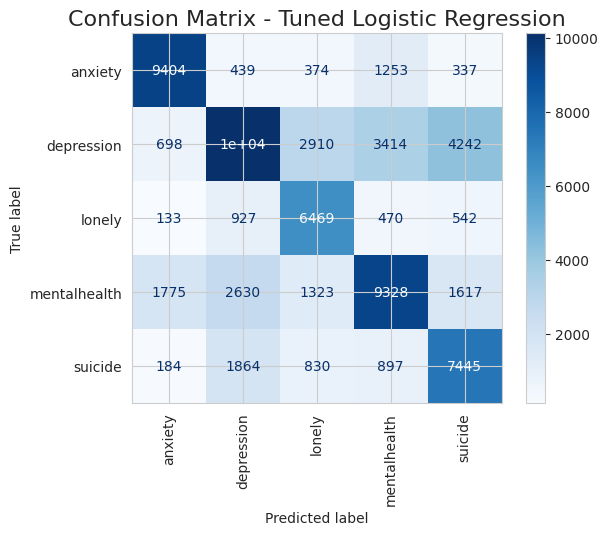

<Figure size 1200x600 with 0 Axes>

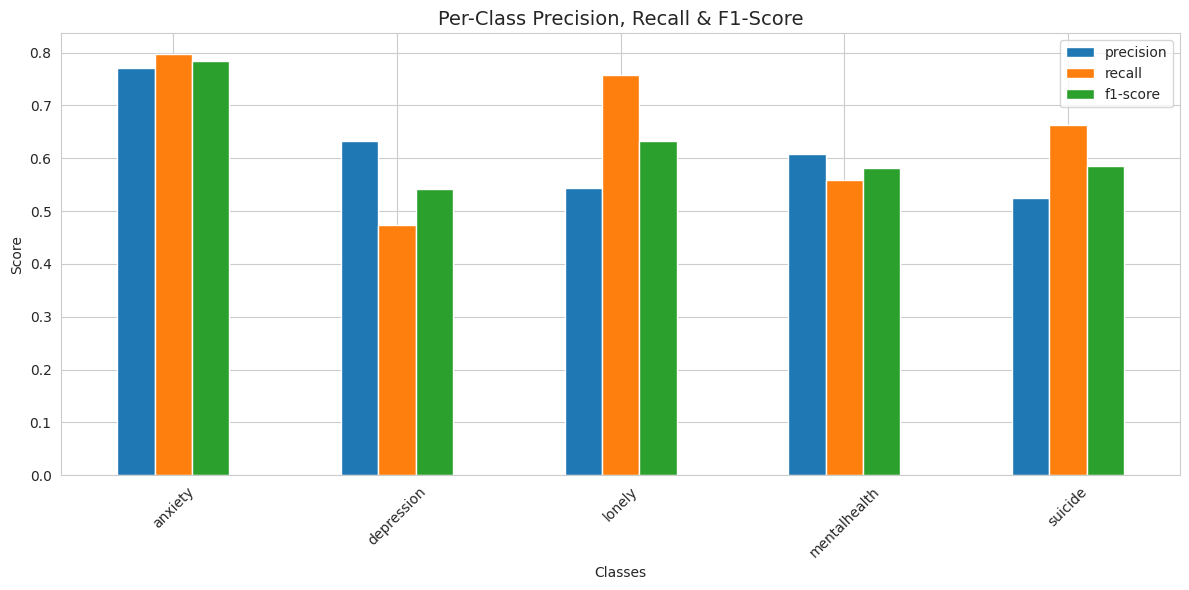

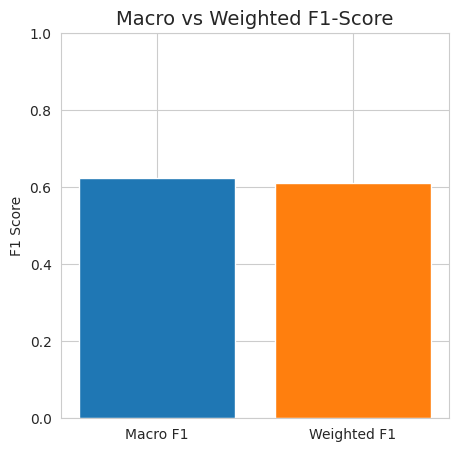


Top features for class 'anxiety':
   anxiety  (coef = 19.059)
   anxious  (coef = 10.047)
   panic  (coef = 5.559)
   nan  (coef = 5.295)
   gad  (coef = 5.157)
   worried  (coef = 4.420)
   nervous  (coef = 4.042)
   fear  (coef = 3.903)
   freaking  (coef = 3.862)
   worrying  (coef = 3.673)

Top features for class 'depression':
   depression  (coef = 11.332)
   depressed  (coef = 7.034)
   depressive  (coef = 4.640)
   birthday removed  (coef = 2.451)
   work removed  (coef = 2.344)
   antidepressants  (coef = 2.314)
   mdd  (coef = 2.213)
   job removed  (coef = 2.116)
   sadness  (coef = 2.025)
   removed  (coef = 2.020)

Top features for class 'lonely':
   lonely  (coef = 10.132)
   loneliness  (coef = 7.807)
   friends  (coef = 3.877)
   couples  (coef = 3.273)
   looking  (coef = 3.262)
   lonelier  (coef = 3.094)
   ghosted  (coef = 3.034)
   connection  (coef = 2.896)
   chat  (coef = 2.752)
   loner  (coef = 2.702)

Top features for class 'mentalhealth':
   mental  (coef = 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# ==============================
# 1️⃣ Confusion Matrix Heatmap
# ==============================
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr_best, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Tuned Logistic Regression", fontsize=16)
plt.show()

# ==============================
# 2️⃣ Classification Metrics as Bar Plot
# ==============================
report = classification_report(y_test, y_pred_lr_best, output_dict=True)
metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :]  # Ignore accuracy/macro avg rows

plt.figure(figsize=(12, 6))
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title("Per-Class Precision, Recall & F1-Score", fontsize=14)
plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ==============================
# 3️⃣ Macro vs Weighted F1 Comparison
# ==============================
plt.figure(figsize=(5, 5))
plt.bar(['Macro F1', 'Weighted F1'], [report['macro avg']['f1-score'], report['weighted avg']['f1-score']], color=['#1f77b4','#ff7f0e'])
plt.title("Macro vs Weighted F1-Score", fontsize=14)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()

# ==============================
# 4️⃣ Top Features per Class (Optional, Very Insightful!)
# ==============================
try:
    feature_names = vectorizer.get_feature_names_out()
    coefs = best_log_reg.coef_

    for i, cls in enumerate(best_log_reg.classes_):
        top_features = np.argsort(coefs[i])[-10:]  # Top 10 words
        print(f"\nTop features for class '{cls}':")
        for feat in reversed(top_features):
            print(f"   {feature_names[feat]}  (coef = {coefs[i][feat]:.3f})")
except:
    print("\nCould not display feature importance (only works for linear models with accessible coefficients)")


**NaiveBayes**

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

print("\n⚠️ Creating 10% validation split from training data for Naive Bayes tuning...")

# -----------------------------
# STEP 1: Small validation split from training
# -----------------------------
sss_nb = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
for train_idx_nb, val_idx_nb in sss_nb.split(X_train_vec, y_train):
    X_train_nb = X_train_vec[train_idx_nb]
    y_train_nb = y_train.iloc[train_idx_nb]
    X_val_nb = X_train_vec[val_idx_nb]
    y_val_nb = y_train.iloc[val_idx_nb]

# Sample weights only for the new training subset
sample_weights_nb = y_train_nb.map(class_weights).values

print(f"🧪 NB tuning train size: {X_train_nb.shape[0]}  |  val size: {X_val_nb.shape[0]}")

# -----------------------------
# STEP 2: Tune alpha manually
# -----------------------------
alpha_grid = [0.01, 0.05, 0.1, 0.5, 1.0]
best_alpha = None
best_acc_nb = 0.0

print("\n🚀 Tuning MultinomialNB (alpha)...")
for alpha in alpha_grid:
    nb_tmp = MultinomialNB(alpha=alpha)
    nb_tmp.fit(X_train_nb, y_train_nb, sample_weight=sample_weights_nb)
    y_val_pred_nb = nb_tmp.predict(X_val_nb)
    acc_val_nb = accuracy_score(y_val_nb, y_val_pred_nb)
    print(f"   alpha={alpha}: val accuracy={acc_val_nb:.4f}")
    if acc_val_nb > best_acc_nb:
        best_acc_nb = acc_val_nb
        best_alpha = alpha

print(f"\n🏆 Best alpha for Naive Bayes: {best_alpha} (val acc={best_acc_nb:.4f})")

# -----------------------------
# STEP 3: Train final NB on FULL training data with best alpha
# -----------------------------
nb_best = MultinomialNB(alpha=best_alpha)
nb_best.fit(X_train_vec, y_train, sample_weight=sample_weights.values)

# -----------------------------
# STEP 4: Evaluate on test set
# -----------------------------
y_pred_nb_best = nb_best.predict(X_test_vec)
acc_nb_best = accuracy_score(y_test, y_pred_nb_best)

print("\n🎯 FINAL TUNED NAIVE BAYES RESULTS")
print(f"Accuracy: {acc_nb_best:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_nb_best))



⚠️ Creating 10% validation split from training data for Naive Bayes tuning...
🧪 NB tuning train size: 250652  |  val size: 27851

🚀 Tuning MultinomialNB (alpha)...
   alpha=0.01: val accuracy=0.5685
   alpha=0.05: val accuracy=0.5685
   alpha=0.1: val accuracy=0.5685
   alpha=0.5: val accuracy=0.5681
   alpha=1.0: val accuracy=0.5672

🏆 Best alpha for Naive Bayes: 0.01 (val acc=0.5685)

🎯 FINAL TUNED NAIVE BAYES RESULTS
Accuracy: 0.5723

📄 Classification Report:
              precision    recall  f1-score   support

     anxiety       0.69      0.75      0.72     11807
  depression       0.60      0.40      0.48     21385
      lonely       0.52      0.73      0.61      8541
mentalhealth       0.56      0.53      0.55     16673
     suicide       0.49      0.66      0.57     11220

    accuracy                           0.57     69626
   macro avg       0.57      0.61      0.58     69626
weighted avg       0.58      0.57      0.57     69626



**svm**

In [46]:
from sklearn.svm import LinearSVC

# -----------------------------
# STEP 1: Stratified 10% subset for SVM tuning
# -----------------------------
print("\n⚠️ Using 10% of train data for Linear SVM tuning...")

sss_svm = StratifiedShuffleSplit(n_splits=1, test_size=0.90, random_state=42)
for small_idx, _ in sss_svm.split(X_train_vec, y_train):
    X_tune_svm = X_train_vec[small_idx]
    y_tune_svm = y_train.iloc[small_idx]

print(f"📉 Tuning sample size (SVM): {X_tune_svm.shape[0]} rows")

# -----------------------------
# STEP 2: Manual small grid search (C) for LinearSVC
# -----------------------------
Cs = [0.5, 1.0, 2.0]
best_acc_svm = 0.0
best_C_svm = None

print("\n🚀 Tuning LinearSVC over C values...")
for C in Cs:
    svm_tmp = LinearSVC(
        C=C,
        class_weight=class_weight_dict,
        max_iter=5000,
        random_state=42
    )
    svm_tmp.fit(X_tune_svm, y_tune_svm)
    y_val_pred = svm_tmp.predict(X_tune_svm)
    acc_val = accuracy_score(y_tune_svm, y_val_pred)
    print(f"   C={C}: tuning accuracy={acc_val:.4f}")
    if acc_val > best_acc_svm:
        best_acc_svm = acc_val
        best_C_svm = C

print(f"\n🏆 Best C for LinearSVC from tuning: {best_C_svm} (acc={best_acc_svm:.4f})")

# -----------------------------
# STEP 3: Train final LinearSVC on FULL data with best C
# -----------------------------
svm_best = LinearSVC(
    C=best_C_svm,
    class_weight=class_weight_dict,
    max_iter=5000,
    random_state=42
)

print("\n🚀 Training best Linear SVM on FULL training data...")
svm_best.fit(X_train_vec, y_train)

# -----------------------------
# STEP 4: Evaluate on test set
# -----------------------------
y_pred_svm_best = svm_best.predict(X_test_vec)
acc_svm_best = accuracy_score(y_test, y_pred_svm_best)

print("\n🎯 FINAL TUNED LINEAR SVM RESULTS")
print(f"Accuracy: {acc_svm_best:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_svm_best))



⚠️ Using 10% of train data for Linear SVM tuning...
📉 Tuning sample size (SVM): 27850 rows

🚀 Tuning LinearSVC over C values...
   C=0.5: tuning accuracy=0.8602
   C=1.0: tuning accuracy=0.9077
   C=2.0: tuning accuracy=0.9448

🏆 Best C for LinearSVC from tuning: 2.0 (acc=0.9448)

🚀 Training best Linear SVM on FULL training data...

🎯 FINAL TUNED LINEAR SVM RESULTS
Accuracy: 0.5962

📄 Classification Report:
              precision    recall  f1-score   support

     anxiety       0.74      0.78      0.75     11807
  depression       0.59      0.51      0.55     21385
      lonely       0.54      0.70      0.61      8541
mentalhealth       0.59      0.53      0.56     16673
     suicide       0.52      0.60      0.56     11220

    accuracy                           0.60     69626
   macro avg       0.60      0.62      0.61     69626
weighted avg       0.60      0.60      0.59     69626



**XGBOOST**

In [42]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data for XGBoost (Needs Numeric Labels)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2. Initialize XGBoost
# n_estimators=100: It will build 100 correction trees
# learning_rate=0.1: The standard speed for learning
# eval_metric='mlogloss': Optimized for multi-class classification
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1 # Uses all CPU cores for speed
)

print("⏳ Training XGBoost (Final Model)... This may take a few minutes.")
xgb_model.fit(X_train_vec, y_train_enc)
print("✅ Training Complete.")

# 3. Predict
y_pred_xgb_enc = xgb_model.predict(X_test_vec)

# Convert predictions back to names (e.g., 0 -> "Anxiety") for readable reports
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

# 4. Evaluate
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("-------------------------------------------------")
print(f"🔥 Model 6: XGBoost Accuracy: {accuracy_xgb:.4f} ({(accuracy_xgb*100):.2f}%)")
print("-------------------------------------------------")

# Compare with Baseline
print(f"Improvement vs Baseline: {accuracy_xgb - 0.6142:+.4f}")

# 5. Detailed Report
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# 6. Visual Confusion Matrix
plt.figure(figsize=(10, 8))
sns.set_style("white")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Reds', xticks_rotation='vertical')
plt.title("Confusion Matrix: XGBoost (Final)", fontsize=16)
plt.show()

⏳ Training XGBoost (Final Model)... This may take a few minutes.


KeyboardInterrupt: 

System Crash

**RANDOM FOREST**

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# 1️⃣ Feature reduction
print("⚠️ Reducing features for Random Forest using SelectKBest...")
selector = SelectKBest(chi2, k=1000)
X_train_reduced = selector.fit_transform(X_train_vec, y_train)
X_test_reduced = selector.transform(X_test_vec)

print("📐 Reduced shape:", X_train_reduced.shape)

# 2️⃣ Safely sample 10% of data for RF
print("\n⚠️ Using 10% subset for Random Forest to prevent RAM crash...")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.90, random_state=42)
for small_idx, _ in sss.split(X_train_reduced, y_train):
    X_train_small = X_train_reduced[small_idx]
    y_train_small = y_train.iloc[small_idx]

print(f"📉 Training subset size: {X_train_small.shape[0]} rows")

# Convert to dense
X_train_small = X_train_small.toarray()
X_test_dense = X_test_reduced.toarray()

# 3️⃣ Train Random Forest
print("\n🚀 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_small, y_train_small)

# 4️⃣ Predict
y_pred_rf = rf_model.predict(X_test_dense)

# 5️⃣ Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\n🎯 Random Forest Accuracy:", round(accuracy_rf, 4))
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_rf))



⚠️ Reducing features for Random Forest using SelectKBest...
📐 Reduced shape: (278503, 1000)

⚠️ Using 10% subset for Random Forest to prevent RAM crash...
📉 Training subset size: 27850 rows

🚀 Training Random Forest...


system crash happens

By looking at this, we get the high accuracy if we train on logistic regression.